In [0]:
# -*- coding: utf-8 -*-

from __future__ import print_function
import keras
from keras.datasets import cifar10
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D

import numpy as np
import os
from keras.optimizers import RMSprop, Adam, Adagrad
import matplotlib.pyplot as plt
import pylab

batch_size = 32
num_classes = 10
epochs = 20
data_augmentation = False
num_predictions = 20
save_dir = os.path.join(os.getcwd(), 'saved_models')
model_name = 'keras_cifar10_trained_model.h5'

# The data, split between train and test sets:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
print('x_train shape:', x_train.shape) # (50000,32,32,3)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

# Convert class vectors to binary class matrices.
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255

In [0]:
class MyCallBack(keras.callbacks.Callback):
    x_train = []
    y_train = []
    train_acc = []
    model_name = ''

    def __init__(self, x, y, model_name):
        super().__init__()
        self.x_train = x
        self.y_train = y
        self.model_name = model_name
        self.train_acc = []
        

    def on_train_begin(self, logs={}):
        self.train_acc = []
        return
        

    def on_train_end(self, logs={}):
        print('train accuracy:')
        print(self.train_acc)
        np.save(self.model_name+'_train_acc', self.train_acc)
        return
      
    def on_epoch_end(self, epoch, logs={}):
        self.train_acc.append(self.model.evaluate(self.x_train, self.y_train, verbose=0)[1])
        return


In [0]:
def conv_model(largeFilter = False, activation= 'relu', dropout = True):
    model = Sequential()
    if largeFilter:
      model.add(Conv2D(32, (5, 5), padding='same',input_shape=x_train.shape[1:]))
      model.add(Activation(activation))
    else:
      model.add(Conv2D(32, (3, 3), padding='same',input_shape=x_train.shape[1:]))
      model.add(Activation(activation))
      model.add(Conv2D(32, (3, 3), padding='same'))
      model.add(Activation(activation))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    if dropout:
        model.add(Dropout(0.25))
    
    
    if largeFilter:
      model.add(Conv2D(32, (5, 5), padding='same',input_shape=x_train.shape[1:]))
      model.add(Activation(activation))
    else:
      model.add(Conv2D(64, (3, 3), padding='same'))
      model.add(Activation(activation))
      model.add(Conv2D(64, (3, 3), padding='same'))
      model.add(Activation(activation))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    if dropout:
        model.add(Dropout(0.25))
    
    
    model.add(Flatten())
    model.add(Dense(512))
    model.add(Activation(activation))
    if dropout:
        model.add(Dropout(0.5))
    
    model.add(Dense(num_classes))
    model.add(Activation('softmax'))
    return model

In [0]:
def dense_model(layerNum):
    model_dense_NN = Sequential()

    model_dense_NN.add(Flatten())
    for i in range(layerNum):
      if i == 0:
        model_dense_NN.add(Dense(512, activation='relu', input_shape=(3072,)))
      else:
        model_dense_NN.add(Dropout(0.5))
        model_dense_NN.add(Dense(512, activation='relu'))
    model_dense_NN.add(Dropout(0.5))
    model_dense_NN.add(Dense(10, activation = 'softmax'))
   
    return model_dense_NN

In [0]:
def train_model(model,model_name, opt= 'RMSprop', batch_size = 32, num_classes = 10, epochs = 20, data_augmentation = False, num_predictions = 20):
    if opt == 'RMSprop':
      opt = keras.optimizers.rmsprop(lr=0.0001, decay=1e-6)
    elif opt== 'Adagrad':
      opt = keras.optimizers.Adagrad(lr=0.01, epsilon=None, decay=0.0)
    elif opt== 'Adam':   
      opt = keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
    
    # Let's train the model using RMSprop
    model.compile(loss='categorical_crossentropy',
                  optimizer=opt,
                  metrics=['accuracy'])
   
    if not data_augmentation:
        print('Not using data augmentation.')
        history = model.fit(x_train, y_train,
                  batch_size=batch_size,
                  epochs=epochs,
                  callbacks=[Callback],
                  validation_data=(x_test, y_test),
                  shuffle=True,
                  verbose = 1)
    else:
        print('Using real-time data augmentation.')
        # This will do preprocessing and realtime data augmentation:
        datagen = ImageDataGenerator(
            featurewise_center=False,  # set input mean to 0 over the dataset
            samplewise_center=False,  # set each sample mean to 0
            featurewise_std_normalization=False,  # divide inputs by std of the dataset
            samplewise_std_normalization=False,  # divide each input by its std
            zca_whitening=False,  # apply ZCA whitening
            zca_epsilon=1e-06,  # epsilon for ZCA whitening
            rotation_range=0,  # randomly rotate images in the range (degrees, 0 to 180)
            # randomly shift images horizontally (fraction of total width)
            width_shift_range=0.1,
            # randomly shift images vertically (fraction of total height)
            height_shift_range=0.1,
            shear_range=0.,  # set range for random shear
            zoom_range=0.,  # set range for random zoom
            channel_shift_range=0.,  # set range for random channel shifts
            # set mode for filling points outside the input boundaries
            fill_mode='nearest',
            cval=0.,  # value used for fill_mode = "constant"
            horizontal_flip=True,  # randomly flip images
            vertical_flip=False,  # randomly flip images
            # set rescaling factor (applied before any other transformation)
            rescale=None,
            # set function that will be applied on each input
            preprocessing_function=None,
            # image data format, either "channels_first" or "channels_last"
            data_format=None,
            # fraction of images reserved for validation (strictly between 0 and 1)
            validation_split=0.0)

        # Compute quantities required for feature-wise normalization
        # (std, mean, and principal components if ZCA whitening is applied).
        datagen.fit(x_train)

        # Fit the model on the batches generated by datagen.flow().
        history = model.fit_generator(datagen.flow(x_train, y_train,
                                         batch_size=batch_size),
                            steps_per_epoch=1563,
                            epochs=epochs,
                            validation_data=(x_test, y_test),
                            workers=4,
                            callbacks=[Callback],
                            verbose = 1)

    # Save model and weights
    if not os.path.isdir(save_dir):
        os.makedirs(save_dir)
    model_path = os.path.join(save_dir, model_name)
    model.save(model_path)
    print('Saved trained model at %s ' % model_path)

   
    test_acc = history.history['val_acc']
    print('test accuracy')
    print(test_acc)
    return test_acc

In [0]:
print(np.shape(x_train))
print(np.shape(x_test))
print(np.shape(y_train))
print(np.shape(y_test))

(50000, 32, 32, 3)
(10000, 32, 32, 3)
(50000, 10)
(10000, 10)


## (a)

In [0]:
train_acc = []
test_acc =[]
for layerNum in range(5):
  Callback = MyCallBack(x_train, y_train, model_name="q1_nn")
  model = dense_model(layerNum)
  test_acc.append(train_model(model = model,model_name ="q1_nn"+str(layerNum), epochs = 20))
  train_acc.append(Callback.train_acc)
  
Callback = MyCallBack(x_train, y_train, model_name="q1_cnn")
model = conv_model()
test_acc.append(train_model(model = model,model_name="q1_cnn", epochs = 20))
train_acc.append(Callback.train_acc)

Not using data augmentation.
Train on 50000 samples, validate on 10000 samples
Epoch 1/20
50000/50000 [==============================] - 7s 147us/step - loss: 2.2182 - acc: 0.2162 - val_loss: 1.9031 - val_acc: 0.3299
Epoch 2/20
50000/50000 [==============================] - 6s 111us/step - loss: 2.0580 - acc: 0.2751 - val_loss: 1.8618 - val_acc: 0.3458
Epoch 3/20
50000/50000 [==============================] - 6s 112us/step - loss: 2.0012 - acc: 0.2947 - val_loss: 1.8314 - val_acc: 0.3624
Epoch 4/20
50000/50000 [==============================] - 6s 111us/step - loss: 1.9649 - acc: 0.3074 - val_loss: 1.8219 - val_acc: 0.3703
Epoch 5/20
50000/50000 [==============================] - 5s 110us/step - loss: 1.9365 - acc: 0.3190 - val_loss: 1.8073 - val_acc: 0.3743
Epoch 6/20
50000/50000 [==============================] - 6s 110us/step - loss: 1.9197 - acc: 0.3265 - val_loss: 1.8076 - val_acc: 0.3753
Epoch 7/20
50000/50000 [==============================] - 6s 110us/step - loss: 1.8999 - acc:

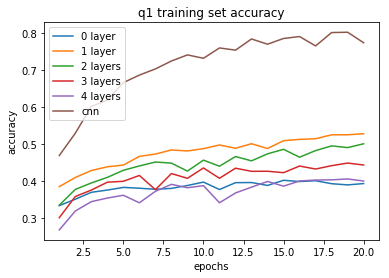

In [0]:
plt.ylabel("accuracy")
plt.xlabel("epochs")
plt.title("q1 training set accuracy")
plt.plot(range(1, 21), np.array(train_acc).T)
pylab.legend(["0 layer","1 layer","2 layers","3 layers","4 layers",'cnn'], loc='best')
plt.show()

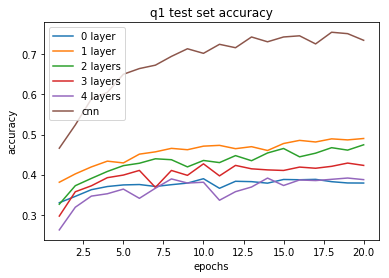

In [0]:
plt.ylabel("accuracy")
plt.xlabel("epochs")
plt.title("q1 test set accuracy")
plt.plot(range(1, 21), np.array(test_acc).T)
pylab.legend(["0 layer","1 layer","2 layers","3 layers","4 layers",'cnn'], loc='best')
plt.show()

The convolutional NN is the best since the model is sparse using shared weights. It is easy to optimized. For the 5 different layer densed NN, 1 hidden layer is the best. In theory,  deep neuron network can get the same result as the single hidden layer NN does. However, Since deep NN has more weights, the optimizer in this case fails to find the best solution.